In [3]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
import os
import pickle

# Func

In [4]:
def load_metadata(root_path, paradigm_setting, session_num):
    meta = pd.read_excel(root_path + 'mat/adp_dataset_master.xlsx', index_col=None)
    meta = meta[meta.paradigm == paradigm_setting].reset_index()
    meta = meta[['mouse','date','area','num']]

    meta.mouse = meta.mouse.astype(int)
    
    if isinstance(session_num, int):
        meta.date = meta.date.astype(int).astype(str) + '_00' + meta.num.astype(int).astype(str) + '_caiman'
        meta.num = meta.num.astype(int)
        meta = meta.loc[meta['num'] == session_num].reset_index()
    elif session_num == '':
        meta.date = meta.date.astype(int).astype(str) + '_caiman'
        meta = meta.head(1) # multisession, only keep one metadata
    return meta

In [5]:
def df_adp_mag(adp_mag, dfof_ad, dfof_tg):
    mag = adp_mag.flatten('F')
    ad = dfof_ad.flatten('F')
    tg = dfof_tg.flatten('F')

    cell_num = [np.arange(adp_mag.shape[0])] * adp_mag.shape[1]
    cell_num = np.concatenate(cell_num)
    stim = [np.arange(nstim)] * adp_mag.shape[0]
    stim_flat = np.sort([item for sublist in stim for item in sublist])
    
    df = pd.DataFrame({'cell':cell_num ,'stim':stim_flat, 'ad':ad, 'tg':tg, 'mag':mag, 'abs_mag':np.abs(mag)})
    return stim_flat, mag, ad, df


def threshold_adp_mag(df, dfof_threshold=0.00025, adp_threshold=10): 
    '''no threshold for dfof_ad bc too few shared stim for side A/B'''
    df_th = df.copy()
    # df_th.loc[df_th[(df.ad) < dfof_threshold].index.to_numpy(),'mag'] = np.nan # not threshold by abs, bc 1-tail ttest originally
    df_th.loc[df_th[np.abs(df.mag) > adp_threshold].index.to_numpy(),'mag'] = np.nan # bug / todo: fix vis_ad and filter normally by vis_ad, not filter by adp_mag
    
    mag_mean = df_th[['mag','stim']].groupby(['stim'], sort=False).mean().to_numpy().flatten()
    mag_median = df_th[['mag','stim']].groupby(['stim'], sort=False).median().to_numpy().flatten()
    mag_std = df_th[['mag','stim']].groupby(['stim'], sort=False).std().to_numpy().flatten()
    mag_sem = df_th[['mag','stim']].groupby(['stim'], sort=False).sem().to_numpy().flatten()
    return df_th, mag_mean, mag_median, mag_std, mag_sem

In [6]:
def mean_confidence_interval(data, confidence=0.95): # find 95% CI among iterations
    a = 1.0 * np.array(data)
    n = a.shape[0]
    m = np.nanmean(a, axis=0)
    se = stats.sem(a, axis=0, nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [7]:
niter = 50
def split_correlate_side(mode, niter=50):

    dfof_ad_side_both = np.empty((ncell, nstim))
    dfof_ad_sideA = np.empty((ncell, nstim))
    dfof_ad_sideB = np.empty((ncell, nstim))
    dfof_tg_sideA = np.empty((ncell, nstim))
    dfof_tg_sideB = np.empty((ncell, nstim))

    niter = 50 # 9 min 100 iter, 6 min 50 iter, 1 min 10 iter
    corr_pearson_iter = np.zeros((1, ncell))
    p_pearson_iter = np.zeros((1, ncell))
    corr_spearman_iter = np.zeros((1, ncell))
    nstim_shared_iter = np.zeros((1, ncell))

    for i in tqdm(np.arange(niter)):
        for icell in np.arange(ncell):
            for istim in np.arange(nstim):
                ntrial_cond = dfof_ad_trial[icell,istim].shape[0]
                dfof_ad_side_both[icell,istim] = np.mean(dfof_ad_trial[icell,istim])

                idx_trial = np.random.choice(np.arange(ntrial_cond), size=ntrial_cond//2, replace=False)
                dfof_ad_sideA[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial,:])
                dfof_tg_sideA[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial,:])

                idx_trial_diff = np.setdiff1d(np.arange(ntrial_cond), idx_trial)
                dfof_ad_sideB[icell,istim] = np.mean(dfof_ad_trial[icell,istim][idx_trial_diff,:])
                dfof_tg_sideB[icell,istim] = np.mean(dfof_tg_trial[icell,istim][idx_trial_diff,:])

        if mode == 'adp':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+epsilon)
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_sideB + 1e-7)
        elif mode == 'adp_alt':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_tg_sideA + dfof_ad_sideA + 1e-7) # (R2-R1)/(R1+R2) to reduce R1 effect
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_tg_sideB + dfof_ad_sideB + 1e-7)
        elif mode == 'adp_stable':
            adp_sideA = (dfof_tg_sideA - dfof_ad_sideA) / (dfof_ad_side_both + 1e-7) # R1 denominator should be stable, so use both sides
            adp_sideB = (dfof_tg_sideB - dfof_ad_sideB) / (dfof_ad_side_both + 1e-7)
        elif mode == 'ad':
            adp_sideA = dfof_ad_sideA # grating tg noad is like bunnytop ad: 8 orientations, unadapted
            adp_sideB = dfof_ad_sideB
        elif mode == 'tg':
            adp_sideA = dfof_tg_sideA # grating tg is like bunnytop tg: 8 orientations, adapted
            adp_sideB = dfof_tg_sideB

        _, _, _, df_sideA = df_adp_mag(adp_sideA, dfof_ad_sideA, dfof_tg_sideA)
        _, _, _, df_sideB = df_adp_mag(adp_sideB, dfof_ad_sideB, dfof_tg_sideB)

        corr_pearson_pop = []
        p_pearson_pop = []
        corr_spearman_pop = []
        nstim_shared = []

        for icell in np.arange(ncell):
            df_sideA_cell = df_sideA.loc[df_sideA['cell'] == icell]
            df_sideB_cell = df_sideB.loc[df_sideB['cell'] == icell]
            _, mag_mean_sideA_cell, _, _, _ = threshold_adp_mag(df_sideA_cell, dfof_threshold=0, adp_threshold=10) # dfof thresh = 0 bc already vis driven
            _, mag_mean_sideB_cell, _, _, _ = threshold_adp_mag(df_sideB_cell, dfof_threshold=0, adp_threshold=10)

            not_nan_mask = (~np.isnan(mag_mean_sideA_cell)) & (~np.isnan(mag_mean_sideB_cell))
            nstim_shared.append(sum(not_nan_mask))

            corr_pearson_cell, p_pearson_cell = stats.pearsonr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask])
            corr_spearman_cell, _ = stats.spearmanr(mag_mean_sideA_cell[not_nan_mask], mag_mean_sideB_cell[not_nan_mask]) # spearman p is only "probably reasonable for datasets larger than 500"
            corr_pearson_pop.append(corr_pearson_cell)
            p_pearson_pop.append(p_pearson_cell)
            corr_spearman_pop.append(corr_spearman_cell)
            
        nstim_shared_iter = np.vstack((nstim_shared_iter, nstim_shared))
        corr_pearson_iter = np.vstack((corr_pearson_iter, corr_pearson_pop))
        p_pearson_iter = np.vstack((p_pearson_iter, p_pearson_pop))
        corr_spearman_iter = np.vstack((corr_spearman_iter, corr_spearman_pop))

    vis_driven_mask = vis_driven.copy().astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
    vis_driven_mask[vis_driven_mask==0] = np.nan
    nstim_shared_iter = nstim_shared_iter[1:,:] * vis_driven_mask # remove the first row of zeros
    corr_pearson_iter = corr_pearson_iter[1:,:] * vis_driven_mask
    p_pearson_iter = p_pearson_iter[1:,:] * vis_driven_mask
    corr_spearman_iter = corr_spearman_iter[1:,:] * vis_driven_mask

    return nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter

# Load

In [12]:
# root_path = 'C:/Users/ll357/Documents/inter/'
root_path = r'C:\Users\GlickfeldLab\Documents\test\inter/'.replace('\\', '/')
meta = load_metadata(root_path, paradigm_setting='bunnytop', session_num='')
print(meta)

dir_name = root_path + 'mat/'
iset = 0
dir_sub = str(meta.area[iset]) + '_i' + str(meta.mouse[iset]) + '_' + str(meta.date[iset])

dfof_trialwise = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'resp_base_trialwise' + '.mat'))
# dfof_trialwise.keys(), dfof_trialwise['dfof_ad_trial'].shape, dfof_trialwise['dfof_ad_trial'][0,0].shape

dfof_ad_trial = dfof_trialwise['dfof_ad_trial'] - dfof_trialwise['dfof_base_trial'] # should subtract baseline!
dfof_tg_trial = dfof_trialwise['dfof_tg_trial'] - dfof_trialwise['dfof_base2_trial']

ncell = dfof_ad_trial.shape[0]
nstim = dfof_ad_trial.shape[1]
print(f'{ncell} cells, {nstim} stimuli')

with open('vis_img_driven.pickle', 'rb') as f:
    img_driven = pickle.load(f)
    vis_driven = pickle.load(f)
vis_driven.shape, img_driven.shape, 


   mouse           date area  num
0   1350  211222_caiman   V1  2.0
324 cells, 30 stimuli


((324, 1), (324, 30))

In [13]:
# test whether subtracting baseline: yes

dfof_ad = np.empty((ncell, nstim))
dfof_tg = np.empty((ncell, nstim))
adp = np.empty((ncell, nstim))

for icell in np.arange(ncell):
    for istim in np.arange(nstim):
        dfof_ad[icell,istim] = np.mean(dfof_ad_trial[icell,istim])
        dfof_tg[icell,istim] = np.mean(dfof_tg_trial[icell,istim])
        adp[icell,istim] = (dfof_tg[icell,istim] - dfof_ad[icell,istim]) / (dfof_ad[icell,istim] + 1e-7)

vis_driven_mask = vis_driven.copy().astype(float).flatten() # apply vis driven mask -> non-vis cells = nan
vis_driven_mask[vis_driven_mask==0] = np.nan

adp = adp * vis_driven_mask.reshape(ncell,1)
adp[np.abs(adp) > 10] = np.nan
np.nanmean(adp), np.nanmedian(adp)

(-0.7069438092392529, -0.760057185439826)

# vis driven criteria test

In [14]:
with open('vis_img_driven_test_sig.pickle', 'rb') as f:
    p_anova = pickle.load(f)
    p_kruskal = pickle.load(f)
    evoked = pickle.load(f)
    p_ttest = pickle.load(f)

## threshold evoked

-0.5576292630078152

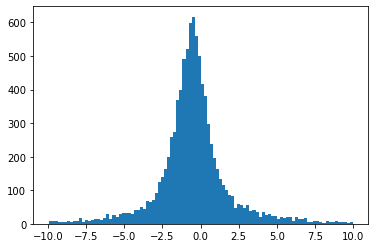

In [15]:
evoked_flat = evoked.flatten()
plt.hist(evoked_flat[np.abs(evoked_flat) < 10], 100);
np.median(evoked_flat) # todo: why is evoked median negative???

In [16]:
# vis driven cells defined by only evoked resp:
evoked_sig = 0.1

# visually driven loose: pass amp threshold for >=1 image
vis_driven = (sum(evoked.T > evoked_sig) > 0).reshape(-1, 1)
print(f'{vis_driven.sum()} cells are visually driven, \n\
    proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# cells responsive to image i loose: pass visually driven AND amp threshold for *this* image
img_driven = vis_driven & (evoked > evoked_sig)
print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
    proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
    1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

# t = np.sum(img_driven, axis=1)
# print(f'img driven cells are driven by {t[t>0]} images')

324 cells are visually driven, 
    proportion 1.0 out of 324 cells
3074 cells are image driven - with overlap between images, 
    proportion 0.32 out of 9720 cell-stim combos. 
    1-30 image evokes resp from [ 96 102  94 101 108 111 101 105 103 109  94 115  98 103 109 100 104  91
  96 110 108 114 112 101  95  94 104  99  87 110] cells


## vis pval vs corr adp_alt

100%|██████████| 50/50 [03:42<00:00,  4.45s/it]


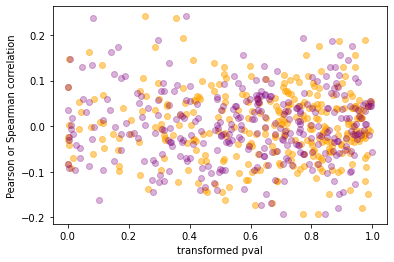

In [17]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='ad', niter=50)
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=50)

corr_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_avg = np.nanmean(corr_spearman_iter, axis=0)

plt.scatter(p_anova**0.33, corr_avg, color='orange', alpha=0.5)
plt.scatter(p_kruskal**0.33, corr_avg, color='purple', alpha=0.3)
# plt.scatter(np.sqrt(p_anova), corr_avg, color='orange', alpha=0.5)
# # plt.scatter(np.sqrt(p_kruskal), corr_avg, color='purple', alpha=0.3)

plt.xlabel('transformed pval')
plt.ylabel('Pearson or Spearman correlation');
# plt.xlim(-0.01, 0.1);

## define vis driven & img driven

In [18]:
# visually driven cells: pass (anova OR kruskal) AND amp threshold for >=1 image
p_sig = 0.1
vis_driven = ((p_anova < p_sig) | (p_kruskal < p_sig)) & (sum(evoked.T > 0.1) > 0).reshape(-1, 1)
print(f'{vis_driven.sum()} cells are visually driven, \n\
    proportion {np.round(vis_driven.sum()/ncell, 2)} out of {ncell} cells')

# cells responsive to image i: pass visually driven (anova OR kruskal) AND t-test AND amp threshold for *this* image
img_driven = vis_driven & (p_ttest < p_sig) & (evoked > 0.1)
print(f'{img_driven.sum()} cells are image driven - with overlap between images, \n\
    proportion {np.round(img_driven.sum() / (ncell*nstim), 2)} out of {ncell*nstim} cell-stim combos. \n\
    1-30 image evokes resp from {np.sum(img_driven, axis=0)} cells')

t = np.sum(img_driven, axis=1)
print(f'img driven cells are driven by {t[t>0]} images')

130 cells are visually driven, 
    proportion 0.4 out of 324 cells
158 cells are image driven - with overlap between images, 
    proportion 0.02 out of 9720 cell-stim combos. 
    1-30 image evokes resp from [ 2 11  3  5  1 12  5  6  9  2  5  2  3  2  7  4  3  7  9  5  2  9  6  6
  6  3  9  5  2  7] cells
img driven cells are driven by [ 1  3  3  3  3  1  1  3  3  1  1  5  1  1  3  4  3  1  1  3  1  1  4  2
  2  1  4  2  1 12  1  1  1  2  1  1  4  1  1  1  1  1  4  2  1  1  1  1
  2  4  9  4  2  4  3  2  2  1  6  3  3  7  1  2  1  1] images


# split side A/B bootstrap

## adp

In [19]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp', niter=50)

# nstim_shared_adp = nstim_shared_iter.copy()
# corr_pearson_adp = corr_pearson_iter.copy()
# p_pearson_adp = p_pearson_iter.copy()
# corr_spearman_adp = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_adp
corr_pearson_iter = corr_pearson_adp
p_pearson_iter = p_pearson_adp
corr_spearman_iter = corr_spearman_adp

100%|██████████| 50/50 [03:46<00:00,  4.54s/it]


0.044814814814814814

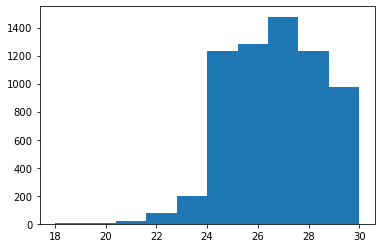

In [20]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


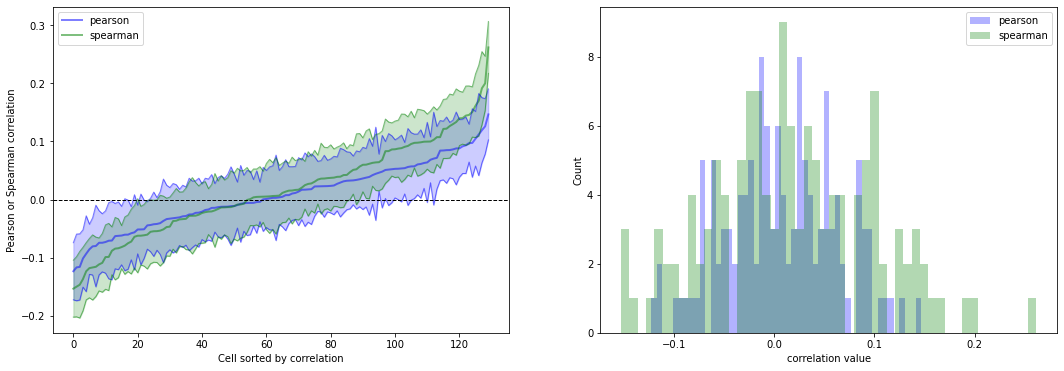

In [21]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

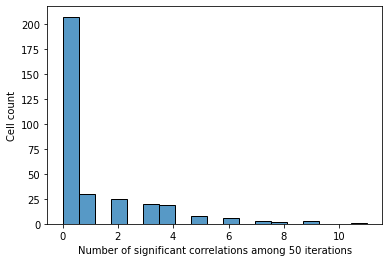

In [22]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

0.02265432098765432

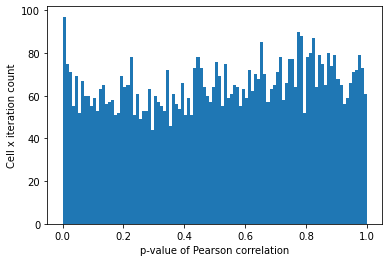

In [23]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## adp alt

In [24]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=50)

# nstim_shared_adp_alt = nstim_shared_iter.copy()
# corr_pearson_adp_alt = corr_pearson_iter.copy()
# p_pearson_adp_alt = p_pearson_iter.copy()
# corr_spearman_adp_alt = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_adp_alt
corr_pearson_iter = corr_pearson_adp_alt
p_pearson_iter = p_pearson_adp_alt
corr_spearman_iter = corr_spearman_adp_alt

100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


0.05080246913580247

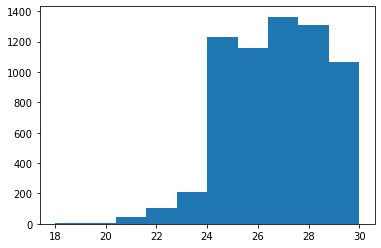

In [25]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


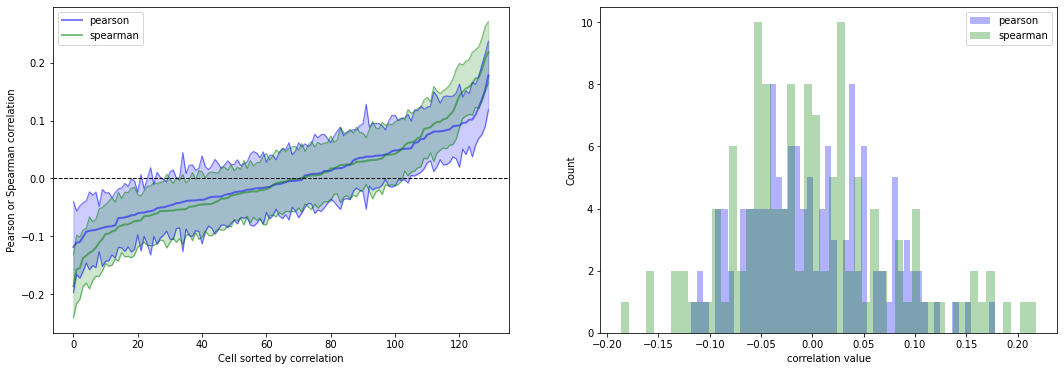

In [26]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

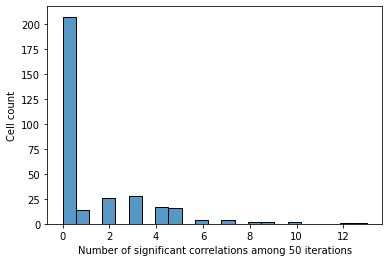

In [27]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

0.02648148148148148

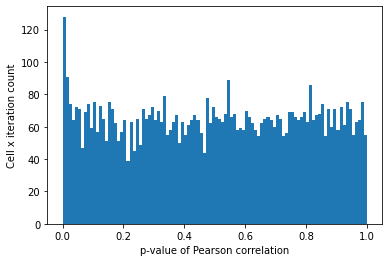

In [28]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## adp stable

In [29]:
nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_stable', niter=50)

nstim_shared_adp_stable = nstim_shared_iter.copy()
corr_pearson_adp_stable = corr_pearson_iter.copy()
p_pearson_adp_stable = p_pearson_iter.copy()
corr_spearman_adp_stable = corr_spearman_iter.copy()

# nstim_shared_iter = nstim_shared_adp_stable
# corr_pearson_iter = corr_pearson_adp_stable
# p_pearson_iter = p_pearson_adp_stable
# corr_spearman_iter = corr_spearman_adp_stable

100%|██████████| 50/50 [03:35<00:00,  4.31s/it]


0.06320987654320988

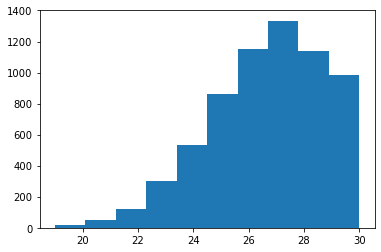

In [30]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


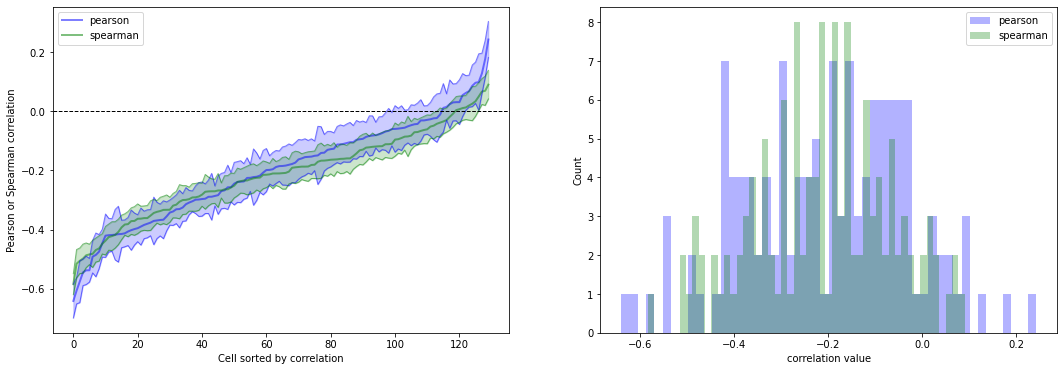

In [31]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

# todo: why is corr of adp_stable mostly negative? bc R1 (both side) is negative & (R2 - R1) is positive???

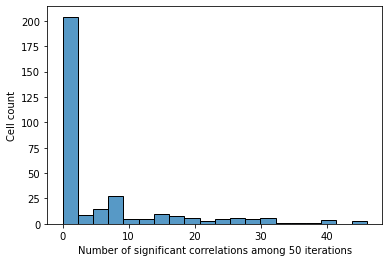

In [32]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
niter = 50
sns.histplot(sig);
plt.xlabel(f'Number of significant correlations among {niter} iterations')
plt.ylabel('Cell count');

0.11950617283950617

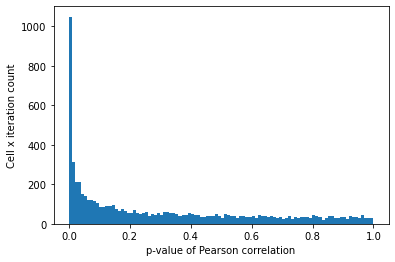

In [33]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## resp ad

In [34]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='ad', niter=50)

# nstim_shared_resp_ad = nstim_shared_iter.copy()
# corr_pearson_resp_ad = corr_pearson_iter.copy()
# p_pearson_resp_ad = p_pearson_iter.copy()
# corr_spearman_resp_ad = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_resp_ad
corr_pearson_iter = corr_pearson_resp_ad
p_pearson_iter = p_pearson_resp_ad
corr_spearman_iter = corr_spearman_resp_ad

100%|██████████| 50/50 [03:33<00:00,  4.27s/it]


0.0

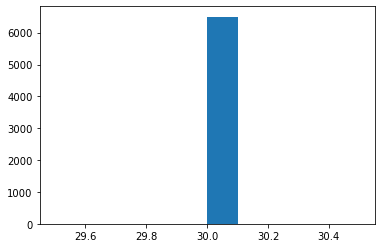

In [35]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


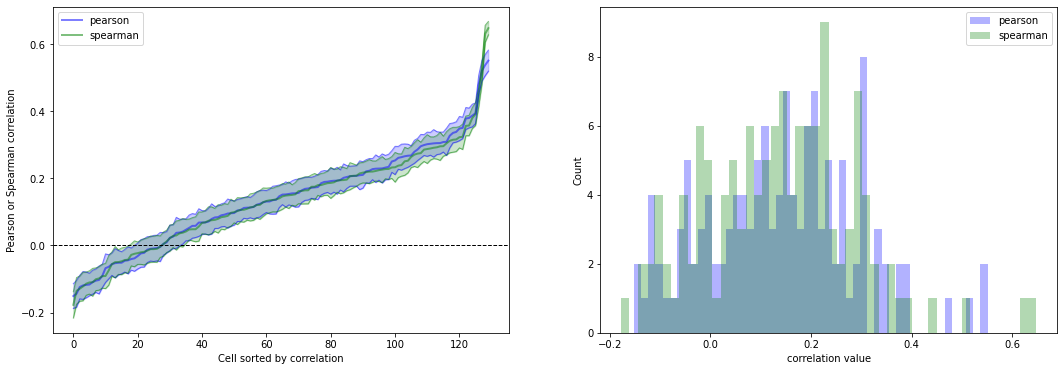

In [36]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

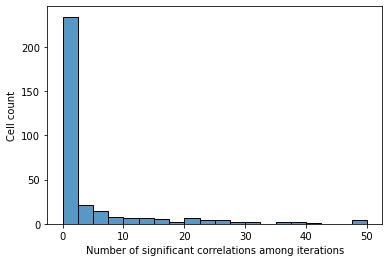

In [37]:
sig = np.sum(p_pearson_iter < 0.1, axis=0)
sns.histplot(sig, bins=20);
plt.xlabel('Number of significant correlations among iterations')
plt.ylabel('Cell count');

0.05382716049382716

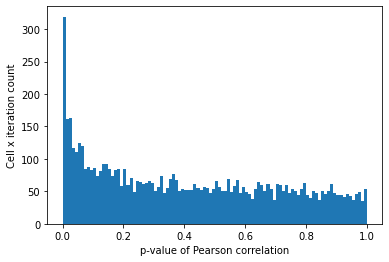

In [38]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

## resp tg

In [39]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='tg', niter=50)

# nstim_shared_resp_tg = nstim_shared_iter.copy()
# corr_pearson_resp_tg = corr_pearson_iter.copy()
# p_pearson_resp_tg = p_pearson_iter.copy()
# corr_spearman_resp_tg = corr_spearman_iter.copy()

nstim_shared_iter = nstim_shared_resp_tg
corr_pearson_iter = corr_pearson_resp_tg
p_pearson_iter = p_pearson_resp_tg
corr_spearman_iter = corr_spearman_resp_tg

100%|██████████| 50/50 [03:33<00:00,  4.28s/it]


0.0

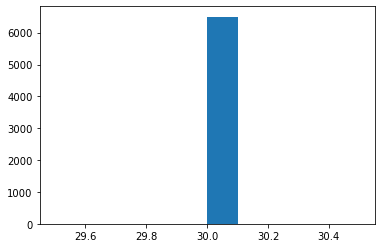

In [40]:
# check shared stim number large enough
plt.hist(nstim_shared_iter.flatten(), 10);
sum(nstim_shared_iter.flatten() < 25) / nstim_shared_iter.flatten().shape[0]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


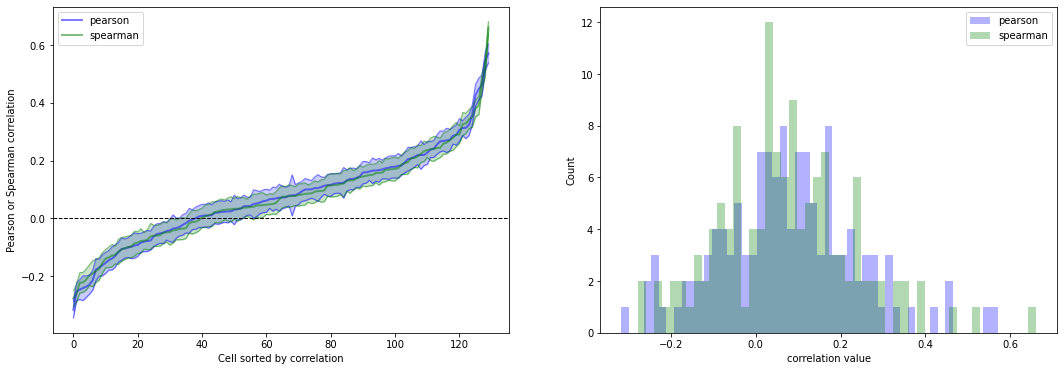

In [41]:
plt.figure(figsize=(18,6))

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)
corr_pearson_avg_sort_id = np.argsort(corr_pearson_avg)
corr_spearman_avg_sort_id = np.argsort(corr_spearman_avg)
corr_pearson_avg_sort = corr_pearson_avg[corr_pearson_avg_sort_id]
corr_spearman_avg_sort = corr_spearman_avg[corr_spearman_avg_sort_id]

_, CI_low_pearson, CI_high_pearson = mean_confidence_interval(corr_pearson_iter)
_, CI_low_spearman, CI_high_spearman = mean_confidence_interval(corr_spearman_iter)
CI_low_pearson_sort = CI_low_pearson[corr_pearson_avg_sort_id]
CI_low_spearman_sort = CI_low_spearman[corr_spearman_avg_sort_id]
CI_high_pearson_sort = CI_high_pearson[corr_pearson_avg_sort_id]
CI_high_spearman_sort = CI_high_spearman[corr_spearman_avg_sort_id]

plt.subplot(121)
plt.plot(np.arange(ncell), corr_pearson_avg_sort, color='blue', alpha=0.5, linewidth=2, label='pearson')
plt.plot(np.arange(ncell), corr_spearman_avg_sort, color='green', alpha=0.5, linewidth=2, label='spearman')

plt.plot(np.arange(ncell), CI_low_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_pearson_sort, color='b', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_pearson_sort, CI_high_pearson_sort, color='b', alpha=0.2) # fill color between CI

plt.plot(np.arange(ncell), CI_low_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.plot(np.arange(ncell), CI_high_spearman_sort, color='g', alpha=0.5, linewidth=1)
plt.fill_between(np.arange(ncell), CI_low_spearman_sort, CI_high_spearman_sort, color='g', alpha=0.2)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Cell sorted by correlation')
plt.ylabel('Pearson or Spearman correlation')
plt.legend();

plt.subplot(122)
plt.hist(corr_pearson_avg, 50, color='blue', alpha=0.3, label='pearson');
plt.hist(corr_spearman_avg, 50, color='green', alpha=0.3, label='spearman');
plt.xlabel('correlation value')
plt.ylabel('Count')
plt.legend();

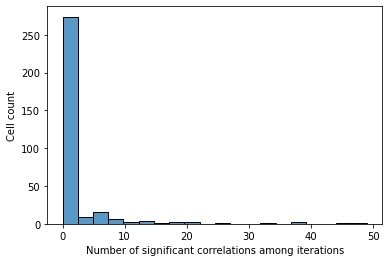

In [42]:
sig = np.sum(p_pearson_iter < 0.05, axis=0)
sns.histplot(sig, bins=20);
plt.xlabel('Number of significant correlations among iterations')
plt.ylabel('Cell count');

0.04148148148148148

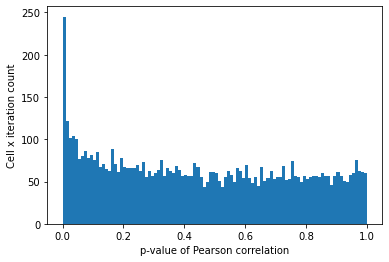

In [43]:
plt.hist(p_pearson_iter.flatten(), 100);
plt.xlabel('p-value of Pearson correlation')
plt.ylabel('Cell x iteration count');
sum(np.array(p_pearson_iter.flatten()) < 0.05) / len(p_pearson_iter.flatten())

# cirvar vs corr (resp or adp)
is it fair to use cirvar? there is no order in 30 imgs  
use OSI-like var? (max-min) / (sum_all)

In [44]:
dfof_trial_avg = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'dfof' + '.mat'))
selectivity_index = np.pi * np.ones((ncell, 1))
resp_sum = np.sum(dfof_trial_avg['dfof_ad'], axis=1)

for icell in np.arange(ncell):
    resp_ad_cell = dfof_trial_avg['dfof_ad'][icell, :]
    selectivity_index[icell] = (np.max(resp_ad_cell) - np.min(resp_ad_cell)) / (np.max(resp_ad_cell) + np.min(resp_ad_cell)) #np.sum(resp_ad_cell)
selectivity_index.shape

(324, 1)

In [51]:
-selectivity_index[selectivity_index<0]

array([ 24.98233222,   2.86461994,  11.31812169,   1.34819246,
        47.68576832,   2.72323704,   2.94774156,   3.36960309,
         3.70599988,  24.48517113,  18.48069657,   3.53954041,
         2.7685415 ,   3.10057021,   2.70750676, 102.83716307,
         5.72133374,   7.50770477,   1.38505266,   4.37557114,
        18.23573683,   5.00330578,   3.64158597,  11.82401386,
        11.07050848,   2.28217053,   4.38510928,   1.66386901,
         2.7738522 ,  12.13490735,   3.04115777,   3.24374786,
         5.87308375,   1.96461693,  19.59352306,   3.09842741,
         2.47832253,   1.66137346,   1.94257768,  18.52680123,
         5.78368731,   3.92224563,   7.91355291,   5.11000418,
        27.3708361 ,   3.28095999,   2.90535064,  29.19569239,
         3.85676083,   6.13015292,   2.70476846,   3.63421062,
         5.32838701,   2.4499332 ,   1.65770517,   2.14093547,
         1.98846631,   6.85085784,   3.0541993 ,   5.29520275,
         2.82431628,  54.21948031,  13.70417287,   4.25

In [97]:
def log_flexible(x):
    res = x.copy()
    res_min = np.min(res)
    res = res + np.abs(res_min) + 1e-6
    res = np.log(res)

    # res[res<0] = -np.log(-res[res<0])
    # res[res>0] = np.log(res[res>0])
    return res

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


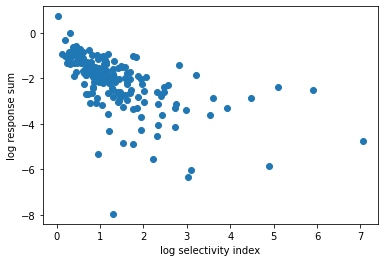

In [104]:
plt.scatter(np.log(selectivity_index), np.log(resp_sum)) # not including negative values
plt.xlabel('log selectivity index')
plt.ylabel('log response sum');
# plt.xlim(-0,10)
# plt.ylim(-4,1.5)

In [105]:
# nstim_shared_iter, corr_pearson_iter, p_pearson_iter, corr_spearman_iter = split_correlate_side(mode='adp_alt', niter=50)

nstim_shared_iter = nstim_shared_adp_alt
corr_pearson_iter = corr_pearson_adp_alt
p_pearson_iter = p_pearson_adp_alt
corr_spearman_iter = corr_spearman_adp_alt

corr_pearson_avg = np.nanmean(corr_pearson_iter, axis=0)
corr_spearman_avg = np.nanmean(corr_spearman_iter, axis=0)

selectivity_index.min(), selectivity_index.max(), corr_pearson_avg[np.argmin(selectivity_index)]

C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
C:\Users\GlickfeldLab\anaconda3\envs\adp\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


(-586.5623629091054, 1149.3433033837082, nan)

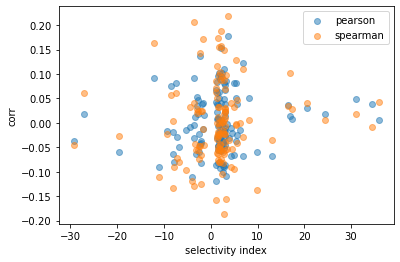

In [89]:
plt.scatter((selectivity_index), (corr_pearson_avg), label='pearson', alpha=0.5)
plt.scatter((selectivity_index), (corr_spearman_avg), label='spearman', alpha=0.5)

# plt.xscale('log') # set log scale for x axis
plt.xlabel('selectivity index')
plt.ylabel('corr')
plt.legend();

# image driven filter vs vis driven filter
visliz neuron trace  
only use img_driven cells for correlating certain img adp or resp

In [128]:
trace = scipy.io.loadmat(os.path.join(dir_name, dir_sub, 'trace_aligned' + '.mat'))
# trace.keys(), trace['trace_avg'].shape

trace_vis = []
for icell in np.arange(ncell):
    trace_cell = trace['trace_avg'][icell]
    if vis_driven[icell]:
        trace_vis.append(trace_cell)

trace_vis = np.array(trace_vis)
trace_vis.shape

(130, 30, 143)

In [130]:
# compare btw stim
trace_mean = np.mean(trace_vis, axis=0)
trace_std = np.std(trace_vis, axis=0)
trace_sem = trace_std / np.sqrt(trace_vis.shape[0])
trace_mean.shape

(30, 143)

In [135]:
import colorcet as cc

long_palette = sns.color_palette(cc.glasbey, n_colors=30)
long_palette

[(0.8392156862745098, 0.0, 0.0),
 (0.5490196078431373, 0.23137254901960785, 1.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.0, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.49411764705882355, 0.8196078431372549),
 (0.4196078431372549, 0.0, 0.30980392156862746),
 (1.0, 0.6470588235294118, 0.1843137254901961),
 (0.3411764705882353, 0.23137254901960785, 0.0),
 (0.0, 0.33725490196078434, 0.34901960784313724),
 (0.0, 0.0, 0.8666666666666667),
 (0.0, 0.9921568627450981, 0.8117647058823529),
 (0.6313725490196078, 0.4588235294117647, 0.4117647058823529),
 (0.7372549019607844, 0.7137254901960784, 1.0),
 (0.5843137254901961, 0.7098039215686275, 0.4666666666666667),
 (0.7490196078431373, 0.011764705882352941, 0.7215686274509804),
 (0.39215686274509803, 0.32941176470588235, 0.4549019607843137),
 (0.4745098039215686, 0.0, 0.0),
 (0.027450980392156862, 0.4549019607843137, 0.8470588235294118),
 (0.9921568627450981, 0.9568627450980393, 0.5647058823529412),
 (0.0, 0.29411764705882354, 0.0),
 (0.5568627450980392, 0.4745098039215686, 0.0),
 (1.0, 0.4470588235294118, 0.4),
 (0.9294117647058824, 0.7215686274509804, 0.7215686274509804),
 (0.36470588235294116, 0.49411764705882355, 0.4),
 (0.6039215686274509, 0.8941176470588236, 1.0),
 (0.9215686274509803, 0.0, 0.4666666666666667),
 (0.6470588235294118, 0.4823529411764706, 0.7215686274509804),
 (0.34901960784313724, 0.0, 0.6392156862745098),
 (0.011764705882352941, 0.7764705882352941, 0.0)]

IndexError: list index out of range

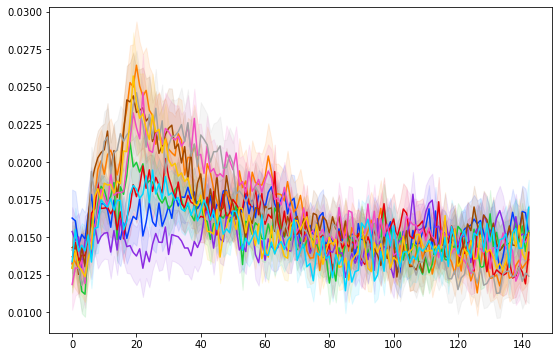

In [132]:
fig, ax = plt.subplots(figsize=(9,6))
for istim in np.arange(nstim):
    ax.plot(np.arange(trace_mean.shape[-1]), trace_mean[istim,:].flatten(), 
            color=sns.color_palette("bright")[istim])
    
    ax.fill_between(np.arange(trace_mean.shape[-1]), 
                    trace_mean[istim,:].flatten() + trace_sem[istim,:].flatten(), 
                    trace_mean[istim,:].flatten() - trace_sem[istim,:].flatten(),
                    color=sns.color_palette("bright")[istim], alpha=0.1)
plt.grid('minor')
plt.xlim(0,70)
plt.xlabel('frame number')
plt.ylabel('dfof')
plt.legend(['inf', '750', '250'])
plt.show()